## 範例重點

* 學習如何在 Keras 中加入 Batch Normalization
* 知道有無批次標準化對訓練的影響
* 比較批次標準化在不同 batch size 下的效果

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend
from keras.utils import np_utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, BatchNormalization
from keras.optimizers import SGD
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


## 準備資料

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
def normalize_cifar10_data(x, y):
    x = x.reshape((len(x), -1)) / 255.
    y = np_utils.to_categorical(y, num_classes=10)
    return x, y

def normalize_result(x, y):
    print('x.shape:', x.shape)
    print('y.shape:', y.shape)

In [4]:
print('Before normalization:')
normalize_result(X_train, y_train)

Before normalization:
x.shape: (50000, 32, 32, 3)
y.shape: (50000, 1)


In [5]:
print('After normalization:')
X_train, y_train = normalize_cifar10_data(X_train, y_train)
X_test, y_test = normalize_cifar10_data(X_test, y_test)
normalize_result(X_train, y_train)

After normalization:
x.shape: (50000, 3072)
y.shape: (50000, 10)


## 定義函數

In [6]:
def train_models(X_train, y_train, X_test, y_test, batch_sizes, should_prenormalize=False, should_normalize_input=False,
                 neuron_numbers=(512, 256, 128,), epochs=50, momentum=0.95, learning_rate=1e-3):
    train_histories = []
    for i, batch_size in enumerate(batch_sizes):
        print('Experiment with batch size: {}'.format(batch_size))
        backend.clear_session() # 清掉舊的 Graph
        model = build_model(X_train, X_train.shape[-1:], y_train.shape[-1], neuron_numbers,
                            should_prenormalize, should_normalize_input)
        model.summary()
        model.compile(optimizer=SGD(lr=learning_rate, momentum=momentum, nesterov=True),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test,),
                  shuffle=True, verbose=2)
        train_histories.append(model.history)
    return train_histories

def build_model(x, input_shape, output_units, neuron_numbers, should_prenormalize, should_normalize_input):
    main_input = Input(shape=input_shape, name='main_input')
    hidden_input = BatchNormalization()(main_input) if should_normalize_input and not should_prenormalize else main_input
    for i, neuron_number in enumerate(neuron_numbers):
        dense_layer, bn_layer = Dense(units=neuron_number, activation='relu', name=f'hidden_layer{i}'), BatchNormalization()
        hidden_input = dense_layer(bn_layer(hidden_input)) if should_prenormalize else bn_layer(dense_layer(hidden_input))
    main_output = Dense(units=output_units, activation='softmax', name='main_output')(hidden_input)
    return Model(inputs=[main_input], outputs=[main_output])

def show_train_histories(train_histories, train_name, val_name, colors, batch_sizes):
    plt.figure(figsize=(8, 6,))
    for i, train_history in enumerate(train_histories):
        show_train_history(train_history, train_name, val_name, colors[i], batch_sizes[i])
    plt.xlabel('Epoch')
    plt.ylabel(train_name)
    plt.title('Train History')
    plt.legend()
    plt.show()

def show_train_history(train_history, train_name, val_name, color, batch_size):
    plt.plot(train_history.history[train_name], '-', label='exp-bz-{}'.format(batch_size), color=color)
    plt.plot(train_history.history[val_name], '--', label='exp-bz-{}'.format(batch_size), color=color)

## 訓練模型

In [7]:
# 設定超參數
batch_sizes = (1024,)

# 設定繪圖參數
colors = ['r']

In [8]:
train_histories = train_models(X_train, y_train, X_test, y_test, batch_sizes)

Experiment with batch size: 1024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 3072)              0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)   

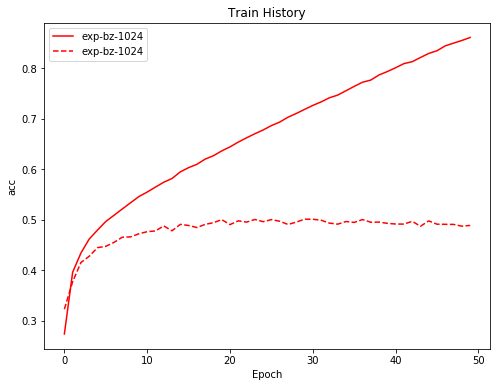

In [9]:
show_train_histories(train_histories, 'acc', 'val_acc', colors, batch_sizes)

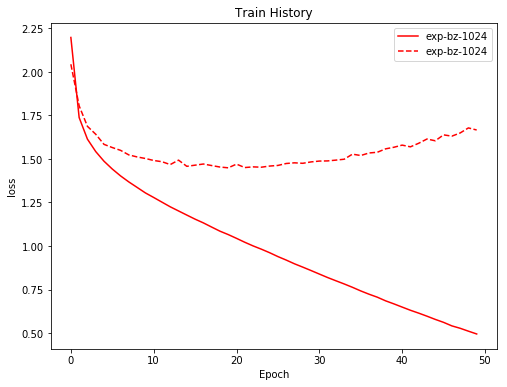

In [10]:
show_train_histories(train_histories, 'loss', 'val_loss', colors, batch_sizes)

## 作業

1. 試比較有批次標準化在 Batch_size 為 2、16、32、128、256 下的差異
2. 請嘗試將批次標準化放在 Activation 之前，並比較訓練結果
3. 請嘗試將批次標準化放在 Input Layer 之後，並比較訓練結果